<a href="https://colab.research.google.com/github/gf4417/MLforIMG-CW/blob/gf4417/Copy_of_CW_Brain_Age_Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Coursework: Age regression from brain MRI

Predicting the age of a patient from their brain MRI scan can have diagnostic value for a number of diseases that may cause structural changes and potential damage to the brain. A discrepancy between the predicted age and the real, chronological age of a patient might indicate the presence of disease. This requires an accurate predictor of brain age which may be learned from a set of healthy reference subjects, given their brain MRI data and their actual age.

**The objective for the coursework is to implement two supervised learning approaches for age regression from brain MRI.** We provide data from a total of 652 healthy subjects, that is split into different development sets and a hold-out test set on which you will evaluate your final prediction accuracy.

Each approach will require a processing pipeline with different components that you will need to implement using methods that were discussed in the lectures and tutorials. There are two dedicated parts in the Jupyter notebook for each approach which contain some detailed instructions and some helper code.

You may find some useful ideas and implementations in the tutorial notebooks. Once you have implemented both approaches and obtained results from your experiments, we ask you to write a short summary report. The reports should contain a short introduction, description of each of your methods and the individual processing steps, your results with a brief discussion. The report should also include some figures and plots to support your findings and illustrate your results.

#### Read the text descriptions and code cells carefully and look out for the cells marked with 'TASK' and 'ADD YOUR CODE HERE'.

### Getting started and familiarise ourselves with the data

The following cells provide some helper functions to load the data, and provide some overview and visualisation of the statistics over the total population of 652 subjects. The data will be split into different subsets to be used for different parts of the coursework. There is a set of 52 subjects to be used in part A to develop an image segmentation method (47 for training, 5 for validation). We then use 500 subjects for training and two-fold cross-validation of age regression approaches in part A and B. **A remaining set of 100 subjects is used to test the final age prediction accuracy and will be made available towards the end of the coursework.**

### Install SimpleITK

In [1]:
! pip install SimpleITK==1.2.4 

     |████████████████████████████████| 42.5MB 76kB/s 


### Downloading the data

In [2]:
! wget https://www.doc.ic.ac.uk/~bglocker/teaching/notebooks/brainage-data.zip
! unzip brainage-data.zip

--2021-02-27 16:20:56--  https://www.doc.ic.ac.uk/~bglocker/teaching/notebooks/brainage-data.zip
Resolving www.doc.ic.ac.uk (www.doc.ic.ac.uk)... 146.169.13.6
Connecting to www.doc.ic.ac.uk (www.doc.ic.ac.uk)|146.169.13.6|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 468654948 (447M) [application/zip]
Saving to: ‘brainage-data.zip’

brainage-data.zip   100%[===================>] 446.94M  30.0MB/s    in 15s     

2021-02-27 16:21:12 (28.9 MB/s) - ‘brainage-data.zip’ saved [468654948/468654948]

Archive:  brainage-data.zip
   creating: data/
   creating: data/brain_age/
   creating: data/brain_age/images/
  inflating: data/brain_age/images/sub-CC110033_T1w_unbiased.nii.gz  
  inflating: data/brain_age/images/sub-CC110037_T1w_unbiased.nii.gz  
  inflating: data/brain_age/images/sub-CC110045_T1w_unbiased.nii.gz  
  inflating: data/brain_age/images/sub-CC110056_T1w_unbiased.nii.gz  
  inflating: data/brain_age/images/sub-CC110062_T1w_unbiased.nii.gz  
  inflating

### Setting data directory

In [3]:
# data directory
data_dir = 'data/brain_age/'

Let's start by loading the meta data of the entire population, that is the data containing information about the subject IDs, their age, and gender.

In [4]:
# Read the meta data using pandas
import pandas as pd

meta_data_all = pd.read_csv(data_dir + 'meta/meta_data_all.csv')
meta_data_all.head() # show the first five data entries

,subject_id,age,gender_code,gender_text
0,CC110033,24,1,MALE
1,CC110037,18,1,MALE
2,CC110045,24,2,FEMALE
3,CC110056,22,2,FEMALE
4,CC110062,20,1,MALE


Let's have a look at some population statistics.

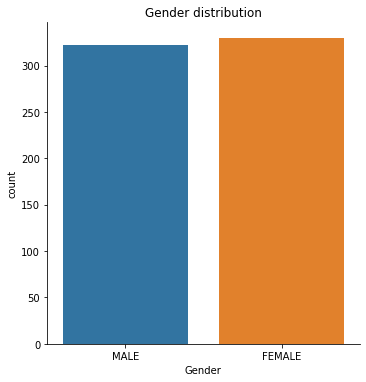

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


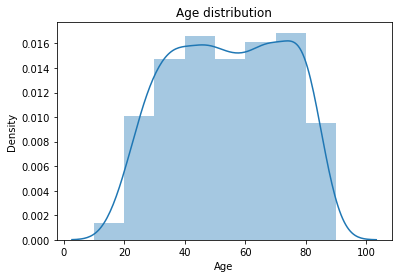

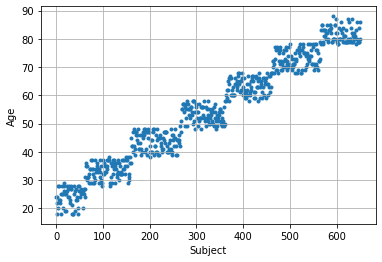

In [5]:
%matplotlib inline

import matplotlib.pyplot as plt
import seaborn as sns

meta_data = meta_data_all

sns.catplot(x="gender_text", data=meta_data, kind="count")
plt.title('Gender distribution')
plt.xlabel('Gender')
plt.show()

sns.distplot(meta_data['age'], bins=[10,20,30,40,50,60,70,80,90])
plt.title('Age distribution')
plt.xlabel('Age')
plt.show()

plt.scatter(range(len(meta_data['age'])),meta_data['age'], marker='.')
plt.grid()
plt.xlabel('Subject')
plt.ylabel('Age')
plt.show()

### Set up a simple medical image viewer and import SimpleITK

In [6]:
import numpy as np
import SimpleITK as sitk
import matplotlib.pyplot as plt

from ipywidgets import interact, fixed
from IPython.display import display

# Calculate parameters low and high from window and level
def wl_to_lh(window, level):
    low = level - window/2
    high = level + window/2
    return low,high

def display_image(img, x=None, y=None, z=None, window=None, level=None, colormap='gray', crosshair=False):
    # Convert SimpleITK image to NumPy array
    img_array = sitk.GetArrayFromImage(img)
    
    # Get image dimensions in millimetres
    size = img.GetSize()
    spacing = img.GetSpacing()
    width  = size[0] * spacing[0]
    height = size[1] * spacing[1]
    depth  = size[2] * spacing[2]
    
    if x is None:
        x = np.floor(size[0]/2).astype(int)
    if y is None:
        y = np.floor(size[1]/2).astype(int)
    if z is None:
        z = np.floor(size[2]/2).astype(int)
    
    if window is None:
        window = np.max(img_array) - np.min(img_array)
    
    if level is None:
        level = window / 2 + np.min(img_array)
    
    low,high = wl_to_lh(window,level)

    # Display the orthogonal slices
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10, 4))

    ax1.imshow(img_array[z,:,:], cmap=colormap, clim=(low, high), extent=(0, width, height, 0))
    ax2.imshow(img_array[:,y,:], origin='lower', cmap=colormap, clim=(low, high), extent=(0, width,  0, depth))
    ax3.imshow(img_array[:,:,x], origin='lower', cmap=colormap, clim=(low, high), extent=(0, height, 0, depth))

    # Additionally display crosshairs
    if crosshair:
        ax1.axhline(y * spacing[1], lw=1)
        ax1.axvline(x * spacing[0], lw=1)
        ax2.axhline(z * spacing[2], lw=1)
        ax2.axvline(x * spacing[0], lw=1)
        ax3.axhline(z * spacing[2], lw=1)
        ax3.axvline(y * spacing[1], lw=1)

    plt.show()
    
def interactive_view(img):
    size = img.GetSize() 
    img_array = sitk.GetArrayFromImage(img)
    interact(display_image,img=fixed(img),
             x=(0, size[0] - 1),
             y=(0, size[1] - 1),
             z=(0, size[2] - 1),
             window=(0,np.max(img_array) - np.min(img_array)),
             level=(np.min(img_array),np.max(img_array)));

### Imaging data

Let's check out the imaging data that is available for each subject. This cell also shows how to retrieve data given a particular subject ID from the meta data.

Imaging data of subject CC110033 with age 24

MR Image


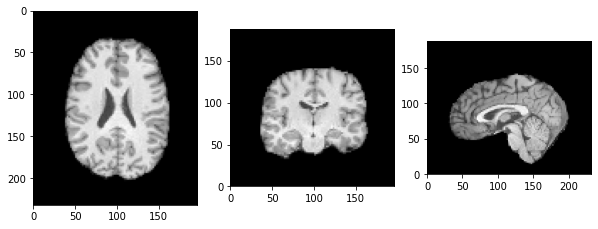

Brain mask


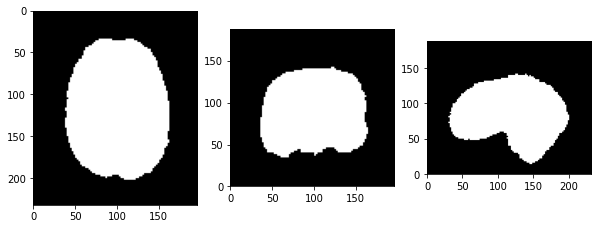

In [7]:
# Subject with index 0
ID = meta_data['subject_id'][0]
age = meta_data['age'][0]

# Image
image_filename = data_dir + 'images/sub-' + ID + '_T1w_unbiased.nii.gz'
img = sitk.ReadImage(image_filename)

# Mask
mask_filename = data_dir + 'masks/sub-' + ID + '_T1w_brain_mask.nii.gz'
msk = sitk.ReadImage(mask_filename)

print('Imaging data of subject ' + ID + ' with age ' + str(age))

print('\nMR Image')
display_image(img, window=400, level=200)

print('Brain mask')
display_image(msk)

## Part A: Age prediction using brain tissue segmentation and volume features

The first approach aims to regress the age of a subject using the volumes of brain tissues as features. The brain tissues include grey matter (GM), white matter (WM), and cerebrospinal fluid (CSF). It is known that with increasing age the ventricles enlarge (filled with CSF), while it is assumed that grey and white matter volume may decrease over time. However, as overall brain volume varies across individuals, taking the absolute volumes of tissues might not be predictive. Instead, relative volumes need to be computed as the ratios between each tissue volume and overall brain volume. To this end, a four-class (GM, WM, CSF, and background) brain segmentation needs to be implemented which will be trained using a total of 52 subjects (47 for training, 5 for validation). The segmentation method is then applied to the remaining 600 brain scans which will be used to train and test the age regression. Brain masks are provided which have been generated with a state-of-the-art neuroimaging brain extraction tool.

Different regression techniques should be explored, and it might be beneficial to investigate what the best set of features is for this task. Are all volume features equally useful, or is it even better to combine some of them and create new features. How does a simple linear regression perform compared to a model with higher order polynomials? Do you need regularisation? How about other regression methods such as regression trees, SVMs or neural networks? The accuracy of different methods should be evaluated using two-fold cross-validation on the set of 500 subjects, and average age prediction accuracy should be compared and reported appropriately. The final prediction accuracy will be evaluated on a hold-out set of 100 subjects.

*Note:* If you struggle with task A-1, you can continue with A-2 using the provided reference segmentations in subfolder `segs_refs`.

### TASK A-1: Brain tissue segmentation

Implement a CNN model for brain tissue segmentation which can provide segmentations of GM, WM, and CSF. For this task (and only for this task), we provide a subset of 52 subjects which are split into 47 images for training and 5 for validation. The template code below has the data handling and main training routines already implemented, so you can focus on implementing a suitable CNN model. A simple model is provided, but this won't perform very well.

Once your model is trained and you are happy with the results on the validation data you should apply it to the 500 subjects later used for training the age regressor. We provide reference segmentations in a subfolder `segs_refs` for all subjects. Calculate Dice similarity coefficients per tissue when comparing your predicted segmentations to the reference segmentations. Summarise the statistics of the 500 Dice scores for each tissue class in [box-and-whisker-plots](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.boxplot.html).

*Note:* Implementing a full-fledged machine learning pipeline with training and testing procedures in Jupyter notebooks is a bit cumbersome and a pain to debug. Also, running bigger training tasks can be unstable. The code below should work as is. However, if you want to get a bit more serious about implementing an advanced CNN approach for image segmentation, you may want to move code into separate Python scripts and run these from the terminal or an IDE such as [PyCharm](https://www.jetbrains.com/pycharm/).

#### Imports

In [12]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm

#### Data Helpers

In [13]:
def zero_mean_unit_var(image, mask):
    """Normalizes an image to zero mean and unit variance."""

    img_array = sitk.GetArrayFromImage(image)
    img_array = img_array.astype(np.float32)

    msk_array = sitk.GetArrayFromImage(mask)

    mean = np.mean(img_array[msk_array>0])
    std = np.std(img_array[msk_array>0])

    if std > 0:
        img_array = (img_array - mean) / std
        img_array[msk_array==0] = 0

    image_normalised = sitk.GetImageFromArray(img_array)
    image_normalised.CopyInformation(image)

    return image_normalised


def resample_image(image, out_spacing=(1.0, 1.0, 1.0), out_size=None, is_label=False, pad_value=0):
    """Resamples an image to given element spacing and output size."""

    original_spacing = np.array(image.GetSpacing())
    original_size = np.array(image.GetSize())

    if out_size is None:
        out_size = np.round(np.array(original_size * original_spacing / np.array(out_spacing))).astype(int)
    else:
        out_size = np.array(out_size)

    original_direction = np.array(image.GetDirection()).reshape(len(original_spacing),-1)
    original_center = (np.array(original_size, dtype=float) - 1.0) / 2.0 * original_spacing
    out_center = (np.array(out_size, dtype=float) - 1.0) / 2.0 * np.array(out_spacing)

    original_center = np.matmul(original_direction, original_center)
    out_center = np.matmul(original_direction, out_center)
    out_origin = np.array(image.GetOrigin()) + (original_center - out_center)

    resample = sitk.ResampleImageFilter()
    resample.SetOutputSpacing(out_spacing)
    resample.SetSize(out_size.tolist())
    resample.SetOutputDirection(image.GetDirection())
    resample.SetOutputOrigin(out_origin.tolist())
    resample.SetTransform(sitk.Transform())
    resample.SetDefaultPixelValue(pad_value)

    if is_label:
        resample.SetInterpolator(sitk.sitkNearestNeighbor)
    else:
        resample.SetInterpolator(sitk.sitkBSpline)

    return resample.Execute(image)


class ImageSegmentationDataset(Dataset):
    """Dataset for image segmentation."""

    def __init__(self, file_list_img, file_list_seg, file_list_msk, img_spacing, img_size):
        self.samples = []
        self.img_names = []
        self.seg_names = []
        for idx, _ in enumerate(tqdm(range(len(file_list_img)), desc='Loading Data')):
            img_path = file_list_img[idx]
            seg_path = file_list_seg[idx]
            msk_path = file_list_msk[idx]

            img = sitk.ReadImage(img_path, sitk.sitkFloat32)

            seg = sitk.ReadImage(seg_path, sitk.sitkInt64)

            msk = sitk.ReadImage(msk_path, sitk.sitkUInt8)

            #pre=processing
            img = zero_mean_unit_var(img, msk)
            img = resample_image(img, img_spacing, img_size, is_label=False)
            seg = resample_image(seg, img_spacing, img_size, is_label=True)
            msk = resample_image(msk, img_spacing, img_size, is_label=True)

            sample = {'img': img, 'seg': seg, 'msk': msk}

            self.samples.append(sample)
            self.img_names.append(os.path.basename(img_path))
            self.seg_names.append(os.path.basename(seg_path))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, item):
        sample = self.samples[item]

        image = torch.from_numpy(sitk.GetArrayFromImage(sample['img'])).unsqueeze(0)
        seg = torch.from_numpy(sitk.GetArrayFromImage(sample['seg'])).unsqueeze(0)
        msk = torch.from_numpy(sitk.GetArrayFromImage(sample['msk'])).unsqueeze(0)

        return {'img': image, 'seg': seg, 'msk': msk}

    def get_sample(self, item):
        return self.samples[item]

    def get_img_name(self, item):
        return self.img_names[item]

    def get_seg_name(self, item):
        return self.seg_names[item]


#### Check that the GPU is up and running

In [14]:
cuda_dev = '0' #GPU device 0 (can be changed if multiple GPUs are available)

use_cuda = torch.cuda.is_available()
device = torch.device("cuda:" + cuda_dev if use_cuda else "cpu")

print('Device: ' + str(device))
if use_cuda:
    print('GPU: ' + str(torch.cuda.get_device_name(int(cuda_dev))))        

Device: cuda:0
GPU: Tesla P4


#### Config and hyper-parameters

Here we set some default hyper-parameters and a starting configuration for the image resolution and others.

**TASK: This needs to be revisited to optimise these values. In particular, you may want to run your final model on higher resolution images.**

In [16]:
rnd_seed = 42 #fixed random seed

img_size = [64, 64, 64]
img_spacing = [3, 3, 3]

num_epochs = 50
learning_rate = 0.001
batch_size = 2
val_interval = 10

num_classes = 4

out_dir = './output'

# Create output directory
if not os.path.exists(out_dir):
    os.makedirs(out_dir)

#### Loading and pre-processing of training and validation data

In [17]:
meta_data_seg_train = pd.read_csv(data_dir + 'meta/meta_data_segmentation_train.csv')
ids_seg_train = list(meta_data_seg_train['subject_id'])
files_seg_img_train = [data_dir + 'images/sub-' + f + '_T1w_unbiased.nii.gz' for f in ids_seg_train]
files_seg_seg_train = [data_dir + 'segs_refs/sub-' + f + '_T1w_seg.nii.gz' for f in ids_seg_train]
files_seg_msk_train = [data_dir + 'masks/sub-' + f + '_T1w_brain_mask.nii.gz' for f in ids_seg_train]

meta_data_seg_val = pd.read_csv(data_dir + 'meta/meta_data_segmentation_val.csv')
ids_seg_val = list(meta_data_seg_val['subject_id'])
files_seg_img_val = [data_dir + 'images/sub-' + f + '_T1w_unbiased.nii.gz' for f in ids_seg_val]
files_seg_seg_val = [data_dir + 'segs_refs/sub-' + f + '_T1w_seg.nii.gz' for f in ids_seg_val]
files_seg_msk_val = [data_dir + 'masks/sub-' + f + '_T1w_brain_mask.nii.gz' for f in ids_seg_val]

We apply some standard pre-processing on the data such as intensity normalization (zero mean unit variance) and downsampling according to the configuration above.

**You may want to use initially the validation data with 5 subjects for training which is more efficient when debugging your training routine and model implementation. Make sure to later train your final model on the actual training data.**

In [18]:
# LOAD TRAINING DATA
dataset_train = ImageSegmentationDataset(files_seg_img_train, files_seg_seg_train, files_seg_msk_train, img_spacing, img_size)
# FOR QUICK DEBUGGING, USE THE VALIDATION DATA FOR TRAINING
#dataset_train = ImageSegmentationDataset(files_seg_img_val, files_seg_seg_val, files_seg_msk_val, img_spacing, img_size)
dataloader_train = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size, shuffle=True)

# LOAD VALIDATION DATA
dataset_val = ImageSegmentationDataset(files_seg_img_val, files_seg_seg_val, files_seg_msk_val, img_spacing, img_size)
dataloader_val = torch.utils.data.DataLoader(dataset_val, batch_size=1, shuffle=False)

Loading Data: 100%|██████████| 5/5 [00:00<00:00,  5.04it/s]


#### Visualise training example

Just to check how a training image looks like after pre-processing.

Image: sub-CC221040_T1w_unbiased.nii.gz


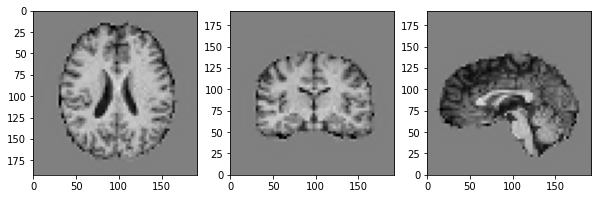

Segmentation


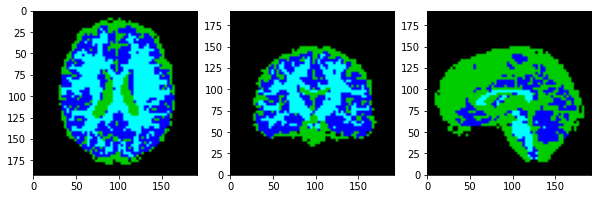

Mask


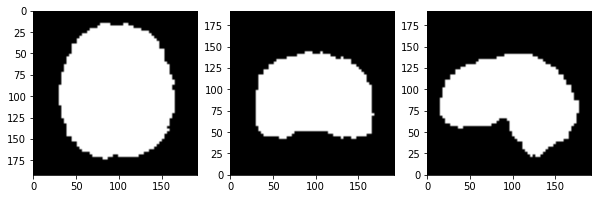

In [19]:
sample = dataset_train.get_sample(0)
img_name = dataset_train.get_img_name(0)
seg_name = dataset_train.get_seg_name(0)
print('Image: ' + img_name)
display_image(sample['img'], window=5, level=0)
print('Segmentation')
display_image(sitk.LabelToRGB(sample['seg']))
print('Mask')
display_image(sample['msk'])

#### The Model

**TASK:** This is the **key part of task A-1** where you have to design a suitable CNN model for brain segmentation. The simple model provided below works to some degree (it let's you run through the upcoming cells), but it will not perform very well. Use what you learned in the lectures to come up with a good architecture. Start with a simple, shallow model and only increase complexity (e.g., number of layers) if needed.

In [25]:
########################################
# BUILD A BETTER MODEL HERE
########################################

class UNet3D(nn.Module):

    def __init__(self, num_classes):
        super(UNet3D, self).__init__()

        self.enc_block_1 = self.make_block(1, 8)
        self.downsample_1 = nn.Conv3d(8, 8, kernel_size=2, stride=2, padding=0)
        self.enc_block_2 = self.make_block(8, 16)
        self.downsample_2 = nn.Conv3d(16, 16, kernel_size=2, stride=2, padding=0)

        self.bottleneck = self.make_block(16, 16)

        # Decoding blocks will also receive residual connections from encoding blocks.
        self.upsample_1 = nn.ConvTranspose3d(16, 16, kernel_size=2, stride=2, padding=0)
        self.dec_block_1 = self.make_block(16, 8)
        self.upsample_2 = nn.ConvTranspose3d(8, 8, kernel_size=2, stride=2, padding=0)
        self.dec_block_2 = self.make_block(16, 8)
        self.final = nn.Conv3d(8, num_classes, kernel_size=1, stride=1, padding=0)

    def forward(self, x):
        enc1 = self.enc_block_1(x)
        ds1 = self.downsample_1(enc1)
        enc2 = self.enc_block_2(ds1)
        ds2 = self.downsample_2(enc2)

        bn = self.bottleneck(ds2)

        us1 = self.upsample_1(bn)
        dec1 = self.dec_block_1(us1)
        us2 = self.upsample_2(dec1)
        dec2 = self.dec_block_2(torch.cat((us2, enc1), dim=1))
        out = self.final(dec2)
        
        return out # cross-entropy loss expects raw logits and applies softmax

    def make_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv3d(in_channels, out_channels, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm3d(out_channels),
            nn.Conv3d(out_channels, out_channels, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
        )

#### TRAINING

Below is an implementation of a full training procedure including a loop for intermediate evaluation of the model on the validation data. Feel free to modify this procedure. For example, in addition to the loss you may want to monitor Dice scores (or others).

In [ ]:
# Added Metrics #
import sklearn.metrics as sk
def dice_score(prd, seg, ignore=None):
  assert prd.max() == seg.max() and prd.min() == seg.min(), "Number of classes differ for segmentation and prediction." 
  if not ignore is None:
    f1_scores = sk.f1_score(prd.flatten(), seg.flatten(), average=None)
    return np.delete(f1_scores, ignore, 0).mean()
  return sk.f1_score(prd.flatten(), seg.flatten(), average=None ) #'weighted')

START TRAINING...
+ TRAINING 	Epoch: 1 	Loss: 0.506873
--------------------------------------------------
+ VALIDATE 	Epoch: 1 	Loss: 0.494666


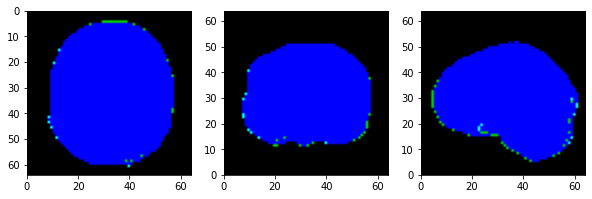

--------------------------------------------------
+ TRAINING 	Epoch: 2 	Loss: 0.299215
+ TRAINING 	Epoch: 3 	Loss: 0.263126
+ TRAINING 	Epoch: 4 	Loss: 0.276920
+ TRAINING 	Epoch: 5 	Loss: 0.225853
+ TRAINING 	Epoch: 6 	Loss: 0.221916
+ TRAINING 	Epoch: 7 	Loss: 0.178488
+ TRAINING 	Epoch: 8 	Loss: 0.148966
+ TRAINING 	Epoch: 9 	Loss: 0.178996
+ TRAINING 	Epoch: 10 	Loss: 0.130643
--------------------------------------------------
+ VALIDATE 	Epoch: 10 	Loss: 0.139917


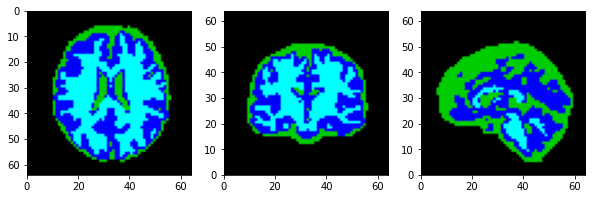

--------------------------------------------------
+ TRAINING 	Epoch: 11 	Loss: 0.186565
+ TRAINING 	Epoch: 12 	Loss: 0.145845
+ TRAINING 	Epoch: 13 	Loss: 0.130915
+ TRAINING 	Epoch: 14 	Loss: 0.106049
+ TRAINING 	Epoch: 15 	Loss: 0.165943
+ TRAINING 	Epoch: 16 	Loss: 0.104941
+ TRAINING 	Epoch: 17 	Loss: 0.100400
+ TRAINING 	Epoch: 18 	Loss: 0.109587
+ TRAINING 	Epoch: 19 	Loss: 0.128606
+ TRAINING 	Epoch: 20 	Loss: 0.117201
--------------------------------------------------
+ VALIDATE 	Epoch: 20 	Loss: 0.107169


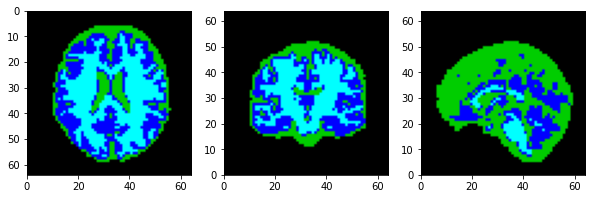

--------------------------------------------------
+ TRAINING 	Epoch: 21 	Loss: 0.141824
+ TRAINING 	Epoch: 22 	Loss: 0.100842
+ TRAINING 	Epoch: 23 	Loss: 0.150593
+ TRAINING 	Epoch: 24 	Loss: 0.085586
+ TRAINING 	Epoch: 25 	Loss: 0.086562
+ TRAINING 	Epoch: 26 	Loss: 0.088524
+ TRAINING 	Epoch: 27 	Loss: 0.094678
+ TRAINING 	Epoch: 28 	Loss: 0.102338
+ TRAINING 	Epoch: 29 	Loss: 0.130171
+ TRAINING 	Epoch: 30 	Loss: 0.109596
--------------------------------------------------
+ VALIDATE 	Epoch: 30 	Loss: 0.096534


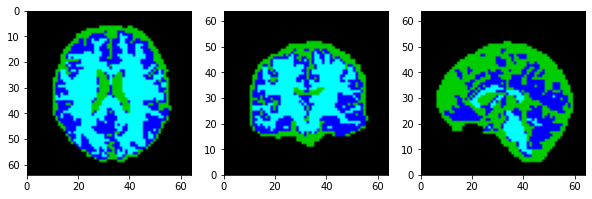

--------------------------------------------------
+ TRAINING 	Epoch: 31 	Loss: 0.089456
+ TRAINING 	Epoch: 32 	Loss: 0.102680
+ TRAINING 	Epoch: 33 	Loss: 0.085390
+ TRAINING 	Epoch: 34 	Loss: 0.090472
+ TRAINING 	Epoch: 35 	Loss: 0.084584
+ TRAINING 	Epoch: 36 	Loss: 0.092067
+ TRAINING 	Epoch: 37 	Loss: 0.124168
+ TRAINING 	Epoch: 38 	Loss: 0.067576
+ TRAINING 	Epoch: 39 	Loss: 0.083780
+ TRAINING 	Epoch: 40 	Loss: 0.104886
--------------------------------------------------
+ VALIDATE 	Epoch: 40 	Loss: 0.091375


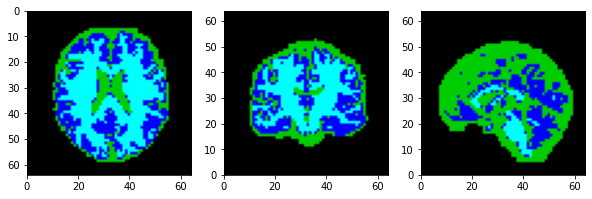

--------------------------------------------------
+ TRAINING 	Epoch: 41 	Loss: 0.085720
+ TRAINING 	Epoch: 42 	Loss: 0.065396
+ TRAINING 	Epoch: 43 	Loss: 0.073763
+ TRAINING 	Epoch: 44 	Loss: 0.082655
+ TRAINING 	Epoch: 45 	Loss: 0.066654
+ TRAINING 	Epoch: 46 	Loss: 0.071937
+ TRAINING 	Epoch: 47 	Loss: 0.077786
+ TRAINING 	Epoch: 48 	Loss: 0.076603
+ TRAINING 	Epoch: 49 	Loss: 0.061639
+ TRAINING 	Epoch: 50 	Loss: 0.071236
--------------------------------------------------
+ VALIDATE 	Epoch: 50 	Loss: 0.087667


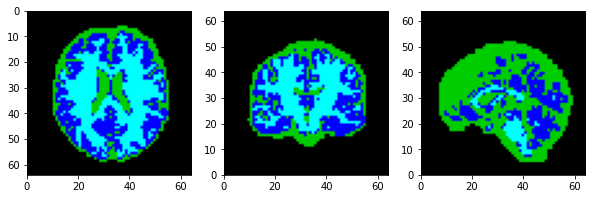

--------------------------------------------------

Finished TRAINING.


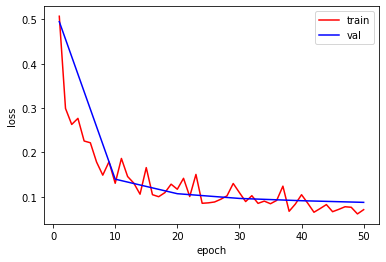

In [ ]:
model_dir = os.path.join(out_dir, 'model')
if not os.path.exists(model_dir):
    os.makedirs(model_dir)

torch.manual_seed(rnd_seed) #fix random seed

model = UNet3D(num_classes=num_classes).to(device)
model.train()
    
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

loss_train_log = []
loss_val_log = []
epoch_val_log = []
    
print('START TRAINING...')
for epoch in range(1, num_epochs + 1):

    # Training
    for batch_idx, batch_samples in enumerate(dataloader_train):
        img, seg = batch_samples['img'].to(device), batch_samples['seg'].to(device)
        optimizer.zero_grad()
        prd = model(img)
        loss = F.cross_entropy(prd, seg.squeeze(1))
        loss.backward()
        optimizer.step()

    loss_train_log.append(loss.item())

    print('+ TRAINING \tEpoch: {} \tLoss: {:.6f}'.format(epoch, loss.item()))
    
    # Validation
    if epoch == 1 or epoch % val_interval == 0:
        loss_val = 0
        sum_pts = 0
        with torch.no_grad():
            for data_sample in dataloader_val:
                img, seg = data_sample['img'].to(device), data_sample['seg'].to(device)
                prd = model(img)
                loss_val += F.cross_entropy(prd, seg.squeeze(1), reduction='sum').item()
                sum_pts += np.prod(img_size)
                
        prd = torch.argmax(prd, dim=1)
        prediction = sitk.GetImageFromArray(prd.cpu().squeeze().numpy().astype(np.uint8))
        

        loss_val /= sum_pts

        loss_val_log.append(loss_val)
        epoch_val_log.append(epoch)

        print('--------------------------------------------------')
        print('+ VALIDATE \tEpoch: {} \tLoss: {:.6f}'.format(epoch, loss_val))
        display_image(sitk.LabelToRGB(prediction))
        print('--------------------------------------------------')

torch.save(model.state_dict(), os.path.join(model_dir, 'model.pt'))

print('\nFinished TRAINING.')

plt.plot(range(1, num_epochs + 1), loss_train_log, c='r', label='train')
plt.plot(epoch_val_log, loss_val_log, c='b', label='val')
plt.legend(loc='upper right')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

#### Loading and pre-processing of testing data

Now that we have trained a model, the next cells are about applying that model to the 500 subjects that are used for training the age regressor. Note, at a later stage you will also need to run the model on the 100 subjects from the hold-out set, once these have been made available. Before testing on the full set, you may want to initially just test on the 5 validation subjects to check everything is working fine.

In [ ]:
meta_data_reg_train = pd.read_csv(data_dir + 'meta/meta_data_regression_train.csv')
ids_seg_test = list(meta_data_reg_train['subject_id'])
files_seg_img_test = [data_dir + 'images/sub-' + f + '_T1w_unbiased.nii.gz' for f in ids_seg_test]#[:5]
files_seg_seg_test = [data_dir + 'segs_refs/sub-' + f + '_T1w_seg.nii.gz' for f in ids_seg_test]#[:5]
files_seg_msk_test = [data_dir + 'masks/sub-' + f + '_T1w_brain_mask.nii.gz' for f in ids_seg_test]#[:5]

dataset_test = ImageSegmentationDataset(files_seg_img_test, files_seg_seg_test, files_seg_msk_test, img_spacing, img_size)
dataloader_test = torch.utils.data.DataLoader(dataset_test, batch_size=1, shuffle=False)

Loading Data: 100%|██████████| 500/500 [01:26<00:00,  5.81it/s]


#### Visualise testing example

Just to check how a testing image looks like after pre-processing.

Image: sub-CC520745_T1w_unbiased.nii.gz


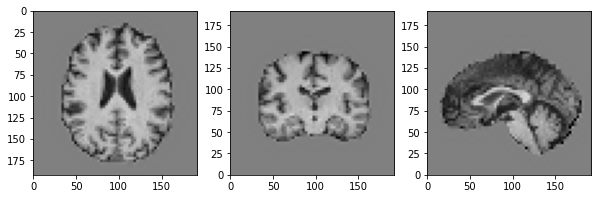

Segmentation


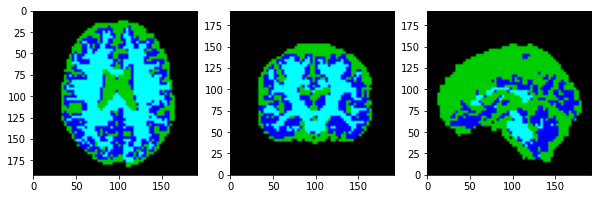

Mask


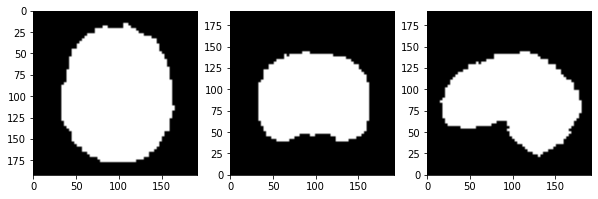

In [ ]:
sample = dataset_test.get_sample(0)
img_name = dataset_test.get_img_name(0)
seg_name = dataset_test.get_seg_name(0)
print('Image: ' + img_name)
display_image(sample['img'], window=5, level=0)
print('Segmentation')
display_image(sitk.LabelToRGB(sample['seg']))
print('Mask')
display_image(sample['msk'])

#### TESTING

Below is an implementation of a full testing procedure that saves the segmentations in an output folder. Feel free to modify this procedure.

**TASK: You will need to add the calculations of Dice scores (and possibly other metrics) to evaluate the segmentation performance.**

START TESTING...
+ TESTING 	Loss: 0.093589
+         	DSC: 0.8852986852560915


Reference segmentation


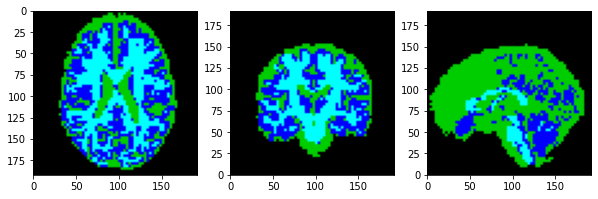

Predicted segmentation


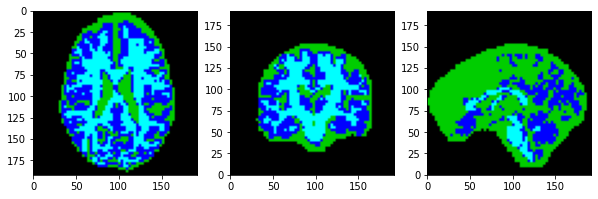


Finished TESTING.


In [ ]:
pred_dir = os.path.join(out_dir, 'pred')
if not os.path.exists(pred_dir):
    os.makedirs(pred_dir)

model = UNet3D(num_classes=num_classes)
model.load_state_dict(torch.load(os.path.join(model_dir, 'model.pt')))
model.to(device)
model.eval()
    
print('START TESTING...')

loss_test = 0
sum_pts = 0
idx_test = 0
dsc = 0
with torch.no_grad():
    for data_sample in dataloader_test:
        img, seg, msk = data_sample['img'].to(device), data_sample['seg'].to(device), data_sample['msk'].to(device)
        prd = model(img)
        loss_test += F.cross_entropy(prd, seg.squeeze(1), reduction='sum').item()
        sum_pts += np.prod(img_size)
        
        prd = torch.argmax(prd, dim=1)

        # TODO: add additional metrics #
        # Add dice score
        dsc += dice_score(prd.cpu() * msk.cpu(), seg.cpu() * msk.cpu(), 0)

        # Add Surface distance?
        ################################

        sample = dataset_test.get_sample(idx_test)
        name = dataset_test.get_seg_name(idx_test)
        prediction = sitk.GetImageFromArray(prd.cpu().squeeze().numpy().astype(np.uint8))
        prediction.CopyInformation(sample['seg'])
        sitk.WriteImage(prediction, os.path.join(pred_dir, name))
        
        idx_test += 1
        
loss_test /= sum_pts
dsc /= len(dataloader_test)
print('+ TESTING \tLoss: {:.6f}'.format(loss_test))
print("+         \tDSC: " + str(dsc))

# Show last testing sample as an example
print('\n\nReference segmentation')
display_image(sitk.LabelToRGB(sample['seg']))
print('Predicted segmentation')
display_image(sitk.LabelToRGB(prediction))

print('\nFinished TESTING.')

### TASK A-2: Feature calculation

Start by calculating the three absolute tissue volumes for each subject. Plot the volumes against the subjects' ages. Taking the absolute volumes of tissues as features, however, might not be predictive. Instead, relative volumes need to be computed as the ratios between each tissue volume and overall brain volume. But you might also want to explore using different combinations or even polynomial features.

Implement a function that constructs a big matrix $X$ with a row for each subject and features across the columns. Start with just calculating three simple features of relative tissue volumes for GM, WM and CSF, and compare these to the absolute volumes plotted above.

*Note:* If you are struggling with the previous task on image segmentation, or if you prefer to work on this and the following tasks first, you can continue here using the provided reference segmentations which can be found in a subfolder `segs_refs`.

In [ ]:
## CALCULATE ABSOLUTE TISSUE VOLUMES

import os

# USE THIS TO RUN THE CALCULATIONS ON YOUR SEGMENTATONS
seg_dir = './output/pred/'

# USE THIS TO RUN THE CALCULATIONS ON OUR REFERENCE SEGMENTATIONS
#seg_dir = data_dir + 'segs_refs/'

meta_data_reg_train = pd.read_csv(data_dir + 'meta/meta_data_regression_train.csv')
ids_reg_train = list(meta_data_reg_train['subject_id'])
files_reg_seg_train = [seg_dir + 'sub-' + f + '_T1w_seg.nii.gz' for f in ids_reg_train]

# THIS MATRIX WILL STORE THE VOLUMES PER TISSUE CLASS
vols = np.zeros((3,len(files_reg_seg_train)))

for idx, _ in enumerate(tqdm(range(len(files_reg_seg_train)), desc='Calculating Features')):
    
    seg_filename = files_reg_seg_train[idx]
    
    if os.path.exists(seg_filename):
        seg = sitk.ReadImage(seg_filename)
        
        ########################################
        # ADD YOUR CODE HERE
        ########################################
        seg_img = sitk.GetArrayFromImage(seg)
        vols[0][idx] = np.sum(seg_img == 1)
        vols[1][idx] = np.sum(seg_img == 2)
        vols[2][idx] = np.sum(seg_img == 3)

Calculating Features: 100%|██████████| 500/500 [00:04<00:00, 103.82it/s]


Plot features versus age.

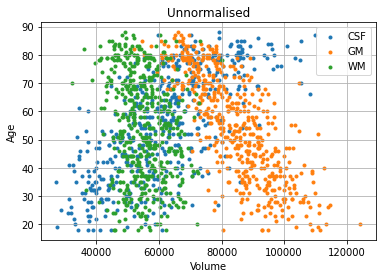

In [ ]:
plt.scatter(vols[0,:],meta_data_reg_train['age'], marker='.')
plt.scatter(vols[1,:],meta_data_reg_train['age'], marker='.')
plt.scatter(vols[2,:],meta_data_reg_train['age'], marker='.')
plt.grid()
plt.title('Unnormalised')
plt.xlabel('Volume')
plt.ylabel('Age')
plt.legend(('CSF','GM','WM'))
plt.show()

In [ ]:
## CALCULATE RELATIVE TISSUE VOLUMES

vols_normalised = np.zeros((3,len(files_reg_seg_train)))

########################################
# ADD YOUR CODE HERE
########################################
vols_normalised = vols / vols.sum(axis=0)

Plot normalised features versus age.

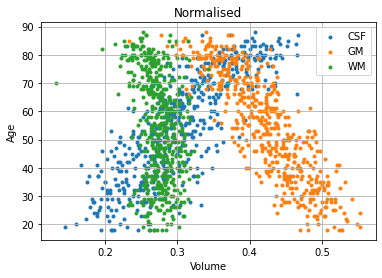

In [ ]:
plt.scatter(vols_normalised[0,:],meta_data_reg_train['age'], marker='.')
plt.scatter(vols_normalised[1,:],meta_data_reg_train['age'], marker='.')
plt.scatter(vols_normalised[2,:],meta_data_reg_train['age'], marker='.')
plt.grid()
plt.title('Normalised')
plt.xlabel('Volume')
plt.ylabel('Age')
plt.legend(('CSF','GM','WM'))
plt.show()

(500, 4)


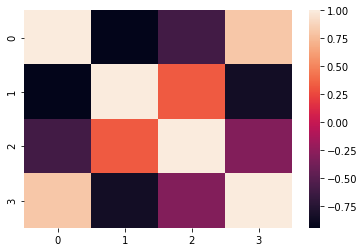

In [ ]:
# Check colinearity of features
import seaborn as sns
X_data = np.concatenate((vols_normalised.T, meta_data_reg_train['age'].values.reshape(-1,1)), 1) #vols_normalised.T #np.concatenate((vols_normalised.T, meta_data_reg_train['age'].values.reshape(-1,1)), 1)
print(X_data.shape)

corr = pd.DataFrame(X_data).corr()
sns.heatmap(corr)

Final data for age regression

In [ ]:
X = vols_normalised.T
y = meta_data_reg_train['age'].values.reshape(-1,1)

z_norm_X = ((X - X.mean(axis=0)) / X.std(axis=0))
log_y = np.log(1+y)

print(X.shape)
print(z_norm_X.shape)

print(y.shape)
print(log_y.shape)

(500, 3)
(500, 3)
(500, 1)
(500, 1)


### TASK A-3: Age regression and cross-validation

Experiment with different regression methods from the [scikit-learn toolkit](http://scikit-learn.org/stable/supervised_learning.html#supervised-learning). Remember to construct the output vectur $y$ containing the age for each of the subjects.

Evaluate the methods using two-fold [cross-validation](http://scikit-learn.org/stable/modules/cross_validation.html#cross-validation) where the dataset of 500 subjects is split into two equally sized sets $(X_1,y_1)$ and $(X_2,y_2)$ which are used for training and testing in an alternating way (so each set is used as $(X_{\text{train}},y_{\text{train}})$ and $(X_{\text{test}},y_{\text{test}})$ exactly once).

Try using at least three different regression methods, and generate a plot allows easy comparison of the performance of the three methods. Useful [error metrics](https://scikit-learn.org/stable/modules/model_evaluation.html#regression-metrics) to report include mean absolute error and r2 score. You might also want to plot the real vs predicted ages.

*Note:* These [scikit-learn examples](https://scikit-learn.org/stable/auto_examples/) might serve as an inspiration.

*Hint:* Be careful how you split the dataset into two folds. Take into account the data characteristics shown at the top of the notebook.

In [ ]:
########################################
# ADD YOUR CODE HERE
########################################
import sklearn
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.metrics import explained_variance_score
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_validate
from sklearn.model_selection import RepeatedKFold
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
##########################################

models = {("Linear Regression", LinearRegression),
          ("Tree Regression", DecisionTreeRegressor),
          ("Support Vector Regression", SVR),
          ("Lasso Regression", Lasso),
          ("Ridge Regression", Ridge)
          }

def get_feature_importances(model, model_name):
  if model_name == "Linear Regression":
    return model.coef_
  elif model_name == "Tree Regression":
    return model.feature_importances_
  elif model_name == "Support Vector Regression":
    return model.coef_.flatten()
  elif model_name == "Lasso Regression":
    print(model.coef_)
    return model.coef_
  else:
    return model.coef_.flatten()

  return None

def initialise(model, model_name):
  if model_name == "Support Vector Regression":
    return model("linear")
  return model()

def repeated_k_fold(X, y, models, k, n):
  results = np.empty((len(models), 3), np.object)
  for i in range(len(models)):
    results[i][0] = []
    results[i][1] = []
  rkf = RepeatedKFold(n_splits=k, n_repeats=n)
  for train_idx, test_idx in rkf.split(X):
    X_train, y_train = X[train_idx], y[train_idx]
    X_test, y_test = X[test_idx], y[test_idx]

    for i, (n, m) in enumerate(models):
      model = m()
      model.fit(X_train, y_train.flatten())
      pred = model.predict(X_test)
      results[i][0] = np.concatenate((results[i][0], y_test.flatten()))
      results[i][1] = np.concatenate((results[i][1], pred.flatten()))
      results[i][2] = n 

  return results

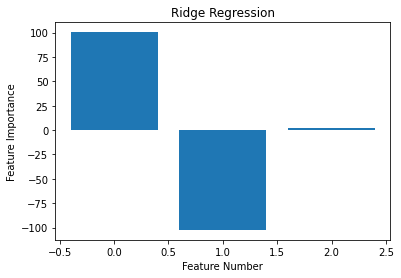

[ 0. -0. -0.]


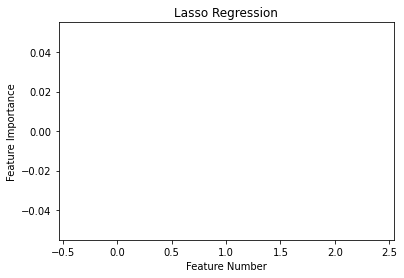

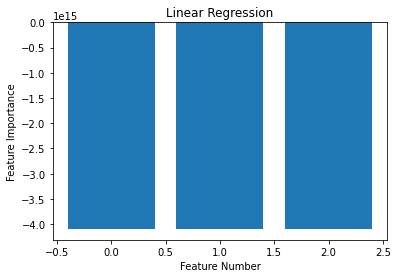

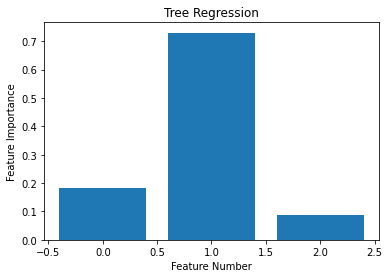

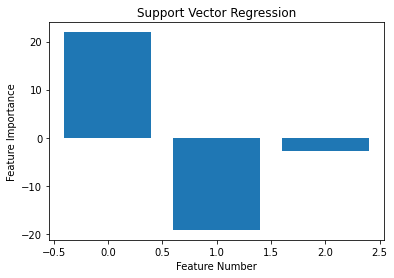

In [ ]:
def evaluate_feature_importances(X, y, models):
  for i, (n, m) in enumerate(models):
      model = initialise(m, n)
      model.fit(X, y.flatten())
      feature_importance = get_feature_importances(model, n)
      fig, ax = plt.subplots()
      ax.bar([x for x in range(len(feature_importance))], feature_importance)
      ax.set_xlabel('Feature Number')
      ax.set_ylabel('Feature Importance')
      ax.set_title(n)
      plt.show()

evaluate_feature_importances(X, y, models)

Error calculation and plotting

In [ ]:
def evaluate_results(actual, predicted, regression_name):
  print(regression_name)
  print('MAE: {0}'.format(mean_absolute_error(actual, predicted))) # Best: Smaller the better
  print('R2: {0}'.format(r2_score(actual, predicted))) # Best: 1.0 
  print('MVS: {0}'.format(explained_variance_score(actual, predicted))) # Best: 1.0
  print('MSE: {0}'.format(mean_squared_error(actual, predicted))) # Best: Smaller the better

  fig, ax = plt.subplots()
  ax.scatter(actual, predicted, marker='.')
  ax.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=2)
  ax.set_xlabel('Real Age')
  ax.set_ylabel('Predicted Age')
  ax.set_title(regression_name)
  plt.show() 

def evaluate_combinations(X, y, m, k, n):
  assert len(m) == 1, "Should only evaluate a model at a time."
  poly = PolynomialFeatures(3)
  fitted = poly.fit_transform(X)
  names = poly.get_feature_names()
  res = []
  for i in range(fitted.shape[1]):
    results = repeated_k_fold(fitted[:, i].reshape(-1, 1), y, m, k, n)
    mae = mean_absolute_error(results[0][0], results[0][1])
    res.append((names[i], mae))

  res.sort(key=lambda tup: tup[1])
  print(res)


evaluate_combinations(X, y, {("Linear Regression", LinearRegression)}, 2, 5)
evaluate_combinations(X, y, {("Support Vector Regression", SVR)}, 2, 5)
evaluate_combinations(X, log_y, {("Support Vector Regression", SVR)}, 2, 5)

[('x1^2', 7.785249507321164), ('x1', 7.855821093685724), ('x1^3', 7.920043781886582), ('x0 x2', 8.258043891979886), ('x0^2 x2', 8.387647204430344), ('x1^2 x2', 8.389005685775562), ('x0', 8.653879301445475), ('x0^2', 9.087096785721153), ('x1 x2', 9.404853974741604), ('x0^2 x1', 9.498372532685433), ('x0^3', 9.669639137713247), ('x0 x2^2', 10.713031078115813), ('x1 x2^2', 11.21309977523501), ('x0 x1 x2', 11.73095460145322), ('x0 x1', 11.78667915054785), ('x0 x1^2', 13.623200080036034), ('x2', 14.85254804118657), ('x2^2', 14.892522493503709), ('x2^3', 14.954078774384602), ('1', 16.0464736)]
[('x1^2', 8.307900111267353), ('x1^3', 8.324607725959721), ('x1', 8.350980924185277), ('x0^2 x2', 8.518038463961188), ('x1^2 x2', 8.739897529685052), ('x0 x2', 8.792145911613671), ('x0^3', 9.046230445249837), ('x0', 9.070415608544256), ('x0^2', 9.090133121197136), ('x1 x2', 9.73223468870746), ('x0^2 x1', 9.954691285631935), ('x0 x2^2', 10.827325553002286), ('x1 x2^2', 11.228156540468001), ('x0 x1 x2', 1

Ridge Regression
MAE: 9.665858371567394
R2: 0.6132903814381436
MVS: 0.6132923410738881
MSE: 131.62645502338557


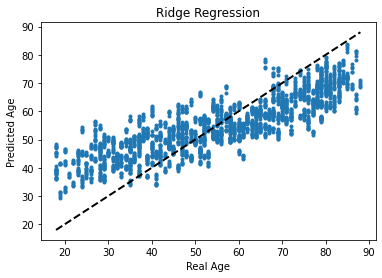

Lasso Regression
MAE: 15.722335867453628
R2: 0.014962981801456054
MVS: 0.014964912689490073
MSE: 335.2824045454693


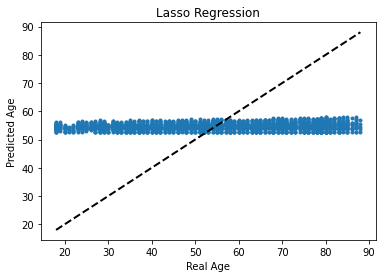

Linear Regression
MAE: 7.89675
R2: 0.7162905707218361
MVS: 0.7163054336859574
MSE: 96.56772068786621


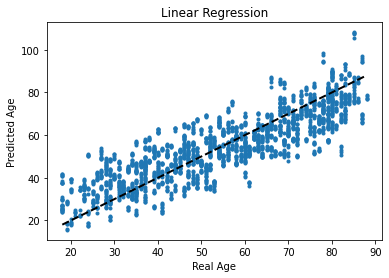

Tree Regression
MAE: 10.4036
R2: 0.4705340605131094
MVS: 0.47072480001171424
MSE: 180.2172


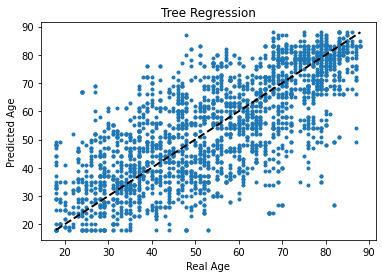

Support Vector Regression
MAE: 8.207390748975175
R2: 0.6980615060596188
MVS: 0.7012043239742212
MSE: 102.7724465201406


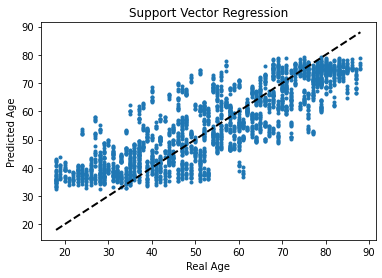

Log: Ridge Regression
MAE: 9.818403932171883
R2: 0.6021428499132786
MVS: 0.6193943047122976
MSE: 135.42080092648524


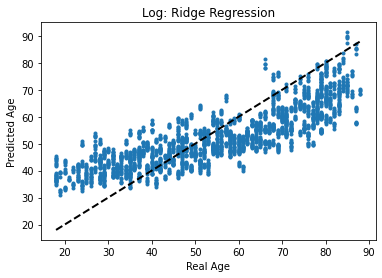

Log: Lasso Regression
MAE: 16.083360222855635
R2: -0.03864115288531966
MVS: -0.004000818829544617
MSE: 353.52793526088334


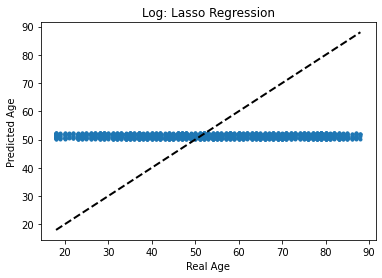

Log: Linear Regression
MAE: 8.787538951472028
R2: 0.6231620358706045
MVS: 0.6251947632438071
MSE: 128.26638634189536


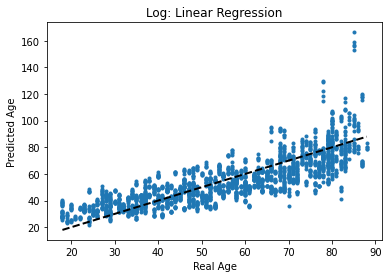

Log: Tree Regression
MAE: 10.2856
R2: 0.4873801645310267
MVS: 0.4875962478091398
MSE: 174.48320000000004


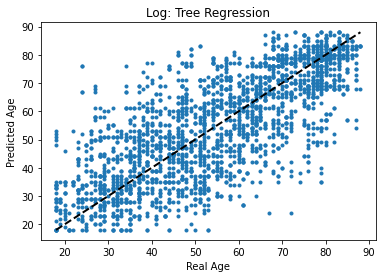

Log: Support Vector Regression
MAE: 7.607588814575985
R2: 0.728618696842714
MVS: 0.7296005786849569
MSE: 92.3715293844094


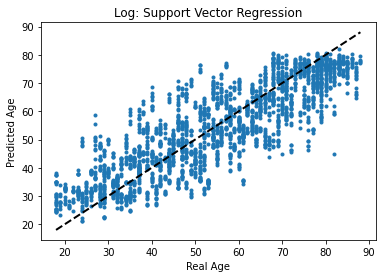

z_norm: Ridge Regression
MAE: 7.8689771990105655
R2: 0.7184465335584755
MVS: 0.7184543902379799
MSE: 95.83388389734525


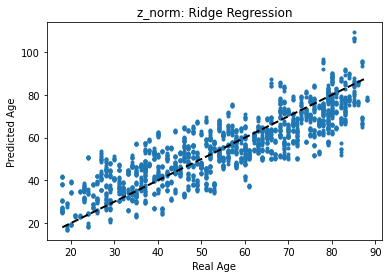

z_norm: Lasso Regression
MAE: 7.953577384295862
R2: 0.7159727400265632
MVS: 0.7159774724476101
MSE: 96.67590244934394


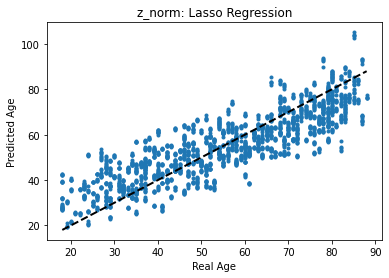

z_norm: Linear Regression
MAE: 7.898307008980791
R2: 0.7165089534385227
MVS: 0.7165169749619956
MSE: 96.49338857545914


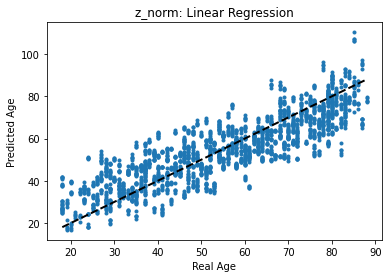

z_norm: Tree Regression
MAE: 10.6076
R2: 0.4523635365978643
MVS: 0.452584104805965
MSE: 186.402


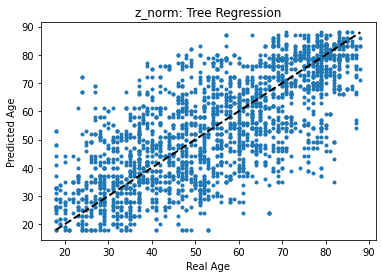

z_norm: Support Vector Regression
MAE: 8.787105887441125
R2: 0.6595726614030675
MVS: 0.6622558258118454
MSE: 115.87310380125055


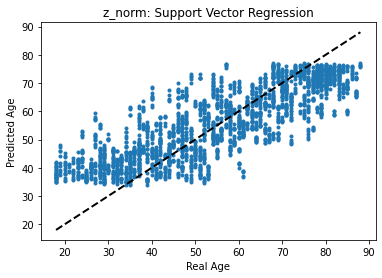

In [ ]:
results = repeated_k_fold(X, y, models, 2, 5)
# applying logs to the expected output as the difference between age has a greater affect as one gets older
log_results = repeated_k_fold(X, log_y, models, 2, 5)
# Applyig z normalization to the input data
z_results = repeated_k_fold(z_norm_X, y, models, 2, 5)

for r in results:
  evaluate_results(r[0], r[1], r[2])

for r in log_results:
  evaluate_results(np.exp(r[0]) - 1, np.exp(r[1]) - 1, "Log: " + r[2])

for r in z_results:
  evaluate_results(r[0], r[1], "z_norm: " + r[2])

0: Tree Regression
MAE: 11.0964
R2: 0.4118177200072687
MVS: 0.41215177419559745
MSE: 200.2028


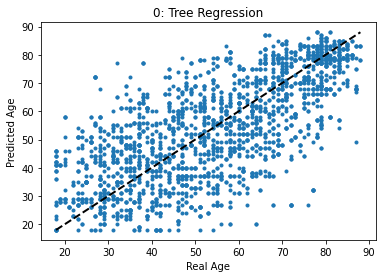

0: Support Vector Regression
MAE: 8.424333275580095
R2: 0.6829841985436778
MVS: 0.6853100705130657
MSE: 107.90439163958514


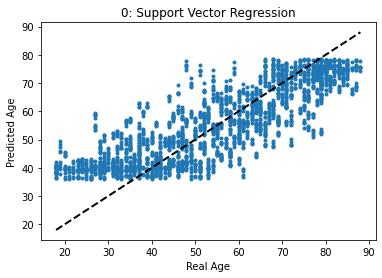

0: Linear Regression
MAE: 8.226894213990347
R2: 0.6905485238040769
MVS: 0.6905492588247286
MSE: 105.32968113103097


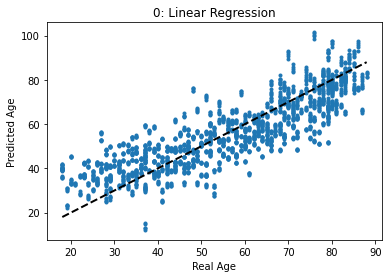

1: Tree Regression
MAE: 11.262
R2: 0.40901375738524215
MVS: 0.4091757286504071
MSE: 201.1572


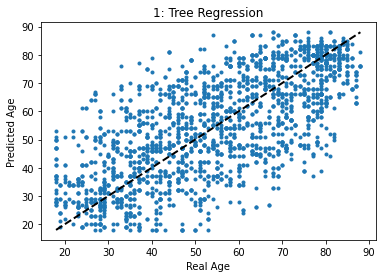

1: Support Vector Regression
MAE: 8.860824642807488
R2: 0.6563601558436921
MVS: 0.6564034311634095
MSE: 116.96656178167537


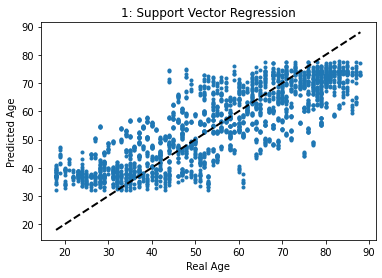

1: Linear Regression
MAE: 8.428877076379585
R2: 0.6770238622416126
MVS: 0.6770238668272207
MSE: 109.93314370710719


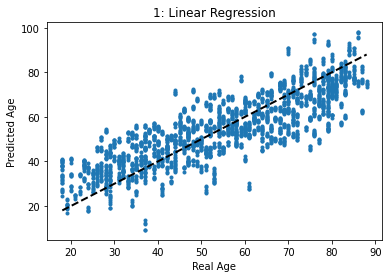

2: Tree Regression
MAE: 17.3564
R2: -0.5517300725543541
MVS: -0.5517132812133951
MSE: 528.1708


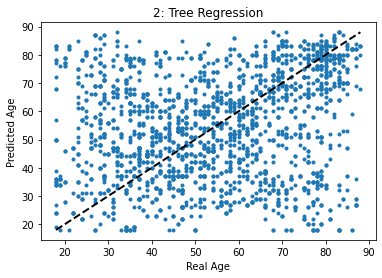

2: Support Vector Regression
MAE: 13.39131950587107
R2: 0.1679583931392341
MVS: 0.18094708740043286
MSE: 283.2065247053738


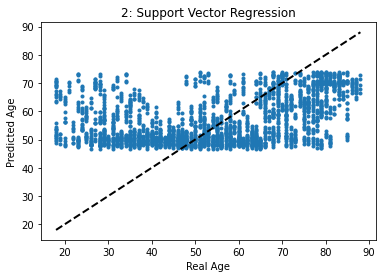

2: Linear Regression
MAE: 13.690240166970918
R2: 0.1796918084405873
MVS: 0.17970531932552114
MSE: 279.21275835640665


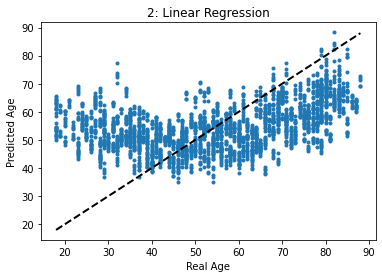

In [ ]:
# Single Features

results_0 = repeated_k_fold(X[:, [0]], y, models, 2, 5)
results_1 = repeated_k_fold(X[:, [1]], y, models, 2, 5)
results_2 = repeated_k_fold(X[:, [2]], y, models, 2, 5)

for r in results_0:
  evaluate_results(r[0], r[1], "0: " + r[2])

for r in results_1:
  evaluate_results(r[0], r[1], "1: " + r[2])

for r in results_2:
  evaluate_results(r[0], r[1], "2: " + r[2])

01: Tree Regression
MAE: 10.5124
R2: 0.47138488571778137
MVS: 0.47167307995750896
MSE: 179.9276


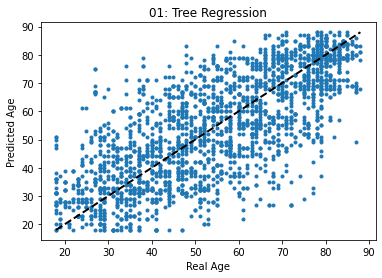

01: Support Vector Regression
MAE: 8.223600547057314
R2: 0.6996621766548996
MVS: 0.7011165576978737
MSE: 102.2276175683795


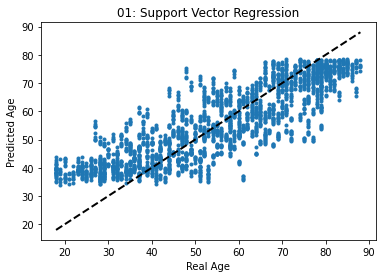

01: Linear Regression
MAE: 8.055609953469467
R2: 0.6989018809554579
MVS: 0.6989055712434173
MSE: 102.48640354856593


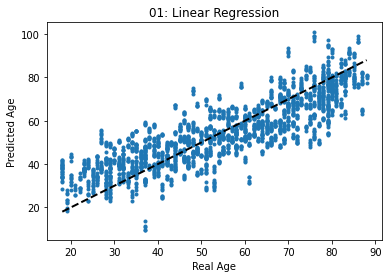

12: Tree Regression
MAE: 10.4776
R2: 0.45489368392612206
MVS: 0.4550307560972172
MSE: 185.5408


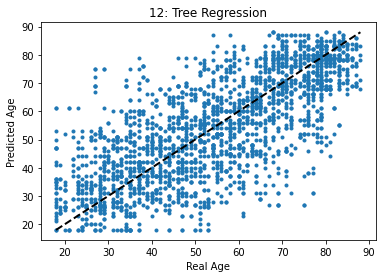

12: Support Vector Regression
MAE: 9.474178503817665
R2: 0.6183799157582122
MVS: 0.6197388561121946
MSE: 129.89410256015523


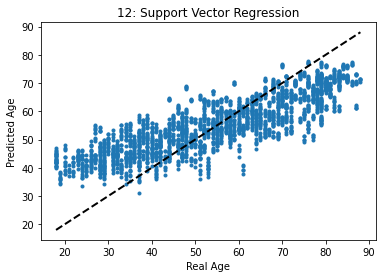

12: Linear Regression
MAE: 8.089224032046083
R2: 0.6963936189021469
MVS: 0.6963978125646326
MSE: 103.34015433856389


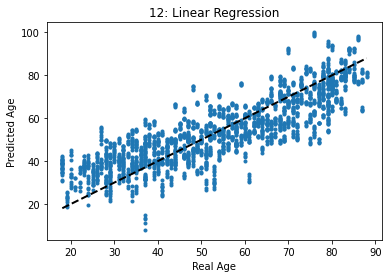

02: Tree Regression
MAE: 10.4292
R2: 0.46854801825358516
MVS: 0.46858305203904327
MSE: 180.8932


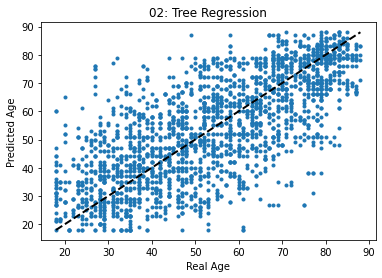

02: Support Vector Regression
MAE: 8.20532107828737
R2: 0.6967048157371594
MVS: 0.6986078520847872
MSE: 103.23423058016475


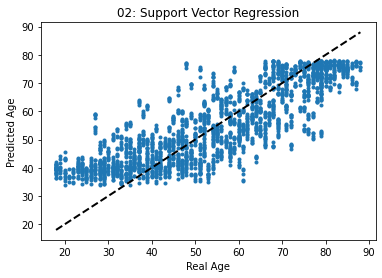

02: Linear Regression
MAE: 8.099903721283633
R2: 0.6971527775125981
MVS: 0.6971553094714944
MSE: 103.08175539553842


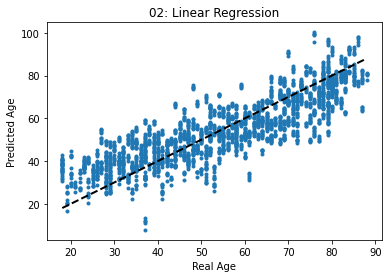

In [ ]:
# Double Features

results_0_1 = repeated_k_fold(X[:, [0,1]], y, models, 2, 5)
results_1_2 = repeated_k_fold(X[:, [1,2]], y, models, 2, 5)
results_0_2 = repeated_k_fold(X[:, [0,2]], y, models, 2, 5)

for r in results_0_1:
  evaluate_results(r[0], r[1], "01: " + r[2])

for r in results_1_2:
  evaluate_results(r[0], r[1], "12: " + r[2])

for r in results_0_2:
  evaluate_results(r[0], r[1], "02: " + r[2])

Comb01: Tree Regression
MAE: 13.6288
R2: 0.11346128984466441
MVS: 0.11346246501759905
MSE: 301.756


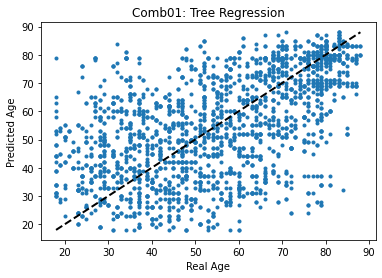

Comb01: Support Vector Regression
MAE: 10.248623743640366
R2: 0.5142626923304658
MVS: 0.5239384446797946
MSE: 165.33304787948384


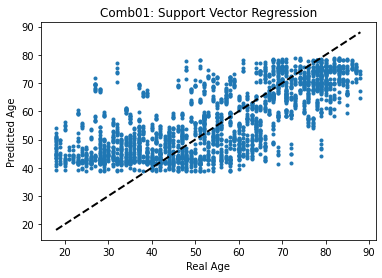

Comb01: Linear Regression
MAE: 10.021749328720691
R2: 0.5451786793622133
MVS: 0.545179104850717
MSE: 154.81000531418243


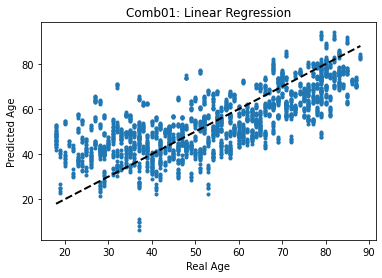

Comb12: Tree Regression
MAE: 13.6288
R2: 0.11346128984466441
MVS: 0.11346246501759905
MSE: 301.756


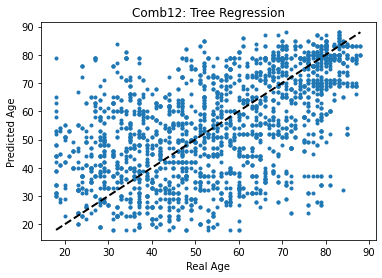

Comb12: Support Vector Regression
MAE: 10.248623743640366
R2: 0.5142626923304658
MVS: 0.5239384446797946
MSE: 165.33304787948384


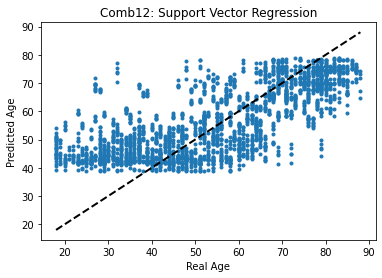

Comb12: Linear Regression
MAE: 10.021749328720691
R2: 0.5451786793622133
MVS: 0.545179104850717
MSE: 154.81000531418243


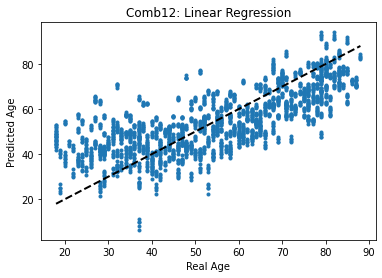

Comb02: Tree Regression
MAE: 13.6288
R2: 0.11346128984466441
MVS: 0.11346246501759905
MSE: 301.756


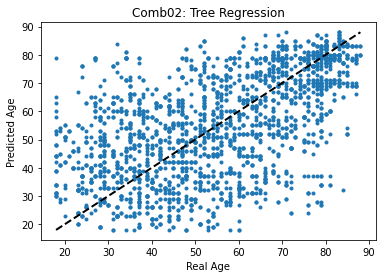

Comb02: Support Vector Regression
MAE: 10.248623743640366
R2: 0.5142626923304658
MVS: 0.5239384446797946
MSE: 165.33304787948384


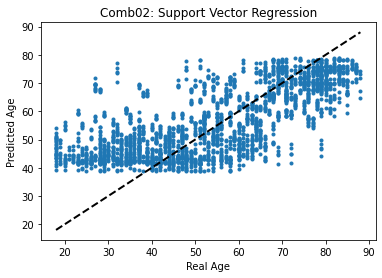

Comb02: Linear Regression
MAE: 10.021749328720691
R2: 0.5451786793622133
MVS: 0.545179104850717
MSE: 154.81000531418243


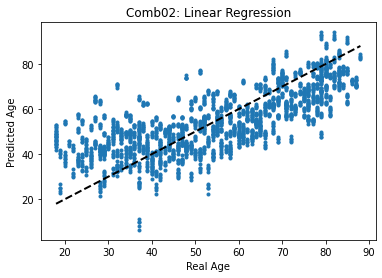

In [ ]:
# Combinations

x_comb_0_1 = (X[:, 0] * X[:, 1]).reshape(-1,1)
#x_comb_0_1 = ((x_comb_0_1 - x_comb_0_1.mean(axis=0)) / x_comb_0_1.std(axis=0)) 
results_comb_0_1 = repeated_k_fold(x_comb_0_1, y, models, 2, 5)

x_comb_1_2 = (X[:, 1] * X[:, 2]).reshape(-1,1)
#x_comb_1_2 = ((x_comb_1_2 - x_comb_1_2.mean(axis=0)) / x_comb_1_2.std(axis=0))
results_comb_1_2 = repeated_k_fold(x_comb_1_2, y, models, 2, 5)

x_comb_0_2 = (X[:, 0] * X[:, 2]).reshape(-1,1)
#x_comb_0_2 = ((x_comb_0_2 - x_comb_0_2.mean(axis=0)) / x_comb_0_2.std(axis=0))
results_comb_0_2 = repeated_k_fold(x_comb_0_2, y, models, 2, 5)

for r in results_comb_0_1:
  evaluate_results(r[0], r[1], "Comb01: " + r[2])

for r in results_comb_0_1:
  evaluate_results(r[0], r[1], "Comb12: " + r[2])

for r in results_comb_0_1:
  evaluate_results(r[0], r[1], "Comb02: " + r[2])

123: Support Vector Regression
MAE: 8.380033199534084
R2: 0.6876520338482276
MVS: 0.6894851822074946
MSE: 106.31557516262278


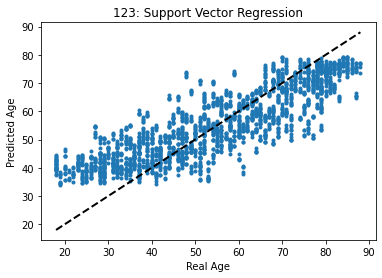

123: Linear Regression
MAE: 8.040983984375
R2: 0.7004281240787888
MVS: 0.7005167796196349
MSE: 101.96690788002014


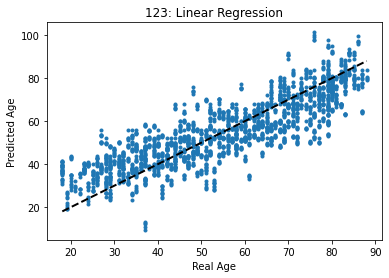

12: Support Vector Regression
MAE: 9.482106545194867
R2: 0.6182332619566685
MVS: 0.6198687010387778
MSE: 129.94401991179674


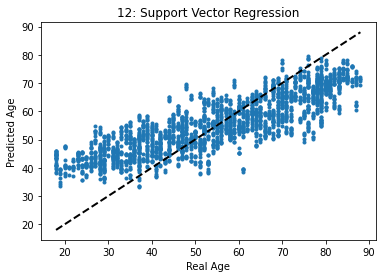

12: Linear Regression
MAE: 8.058919511007893
R2: 0.7004250247904928
MVS: 0.7004250380127801
MSE: 101.96796280162518


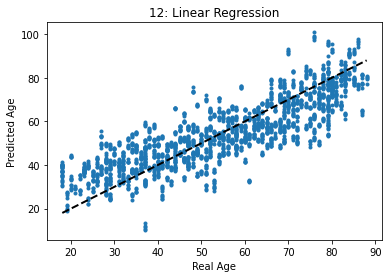

best: Support Vector Regression
MAE: 8.838591479434163
R2: 0.66442613116059
MVS: 0.6644610163347966
MSE: 114.22110191642099


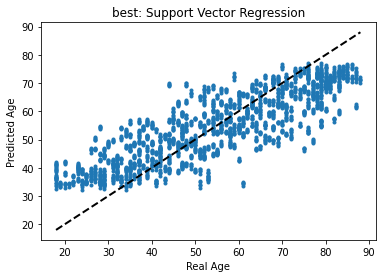

best: Linear Regression
MAE: 7.955910263038725
R2: 0.7014288988429886
MVS: 0.7014299801172077
MSE: 101.62626873331784


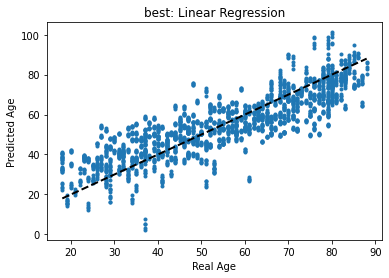

Log 123: Support Vector Regression
MAE: 7.583231649534355
R2: 0.7264118994425315
MVS: 0.7275336812064934
MSE: 93.1226690116602


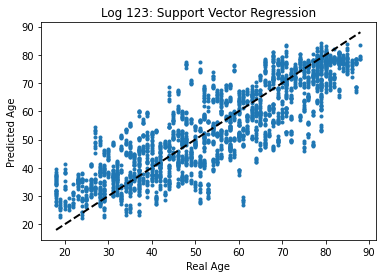

Log 123: Linear Regression
MAE: 8.784822723647236
R2: 0.6348543599231681
MVS: 0.6380875028788621
MSE: 124.28660644465074


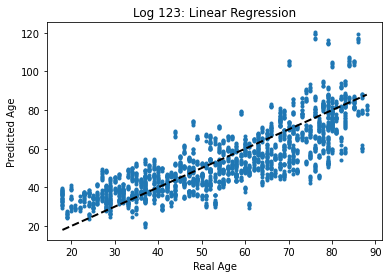

Log 12: Support Vector Regression
MAE: 7.693145399341179
R2: 0.7192076263044093
MVS: 0.7203094448928932
MSE: 95.57482662211163


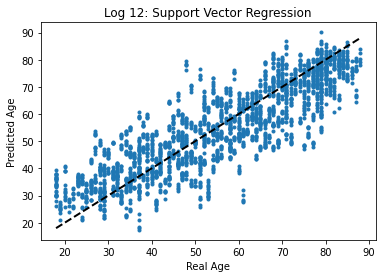

Log 12: Linear Regression
MAE: 8.819165066914492
R2: 0.6309685138642392
MVS: 0.6336302034076756
MSE: 125.60925299118753


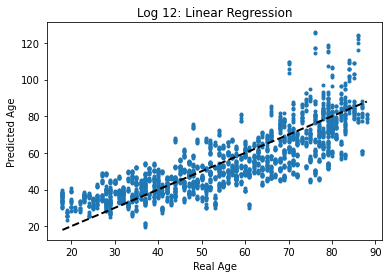

Log best: Support Vector Regression
MAE: 8.117711508292327
R2: 0.6919334127857364
MVS: 0.6940402242741319
MSE: 104.85829894008697


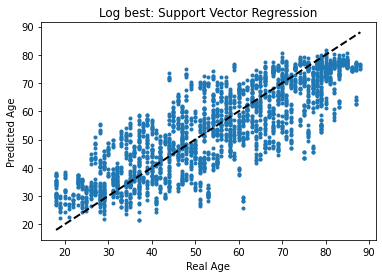

Log best: Linear Regression
MAE: 8.367808802851137
R2: 0.6665165637149921
MVS: 0.6691950491364823
MSE: 113.50957002428775


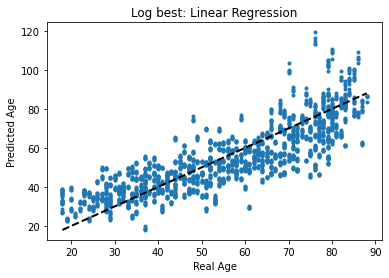

In [ ]:
# Narrowing down
final_models = {("Linear Regression", LinearRegression),
                ("Support Vector Regression", SVR)}

results_1_2_3 = repeated_k_fold(X, y, final_models, 2, 5)
for r in results_1_2_3:
  evaluate_results(r[0], r[1], "123: " + r[2])

results_1_2 = repeated_k_fold(X[:, [1,2]], y, final_models, 2, 5)
for r in results_1_2:
  evaluate_results(r[0], r[1], "12: " + r[2])

#best_X = np.concatenate(((X[:, 1] ** 2).reshape(-1, 1), (X[:,0] * X[:,2]).reshape(-1, 1)), axis=1)
best_X = np.concatenate((((X[:, 1] ** 2) * X[:,2]).reshape(-1, 1), (X[:,0]).reshape(-1, 1)), axis=1)
best_combo = repeated_k_fold(best_X, y, final_models, 2, 5)
for r in best_combo:
  evaluate_results(r[0], r[1], "best: " + r[2])

####################################################################

log_results = repeated_k_fold(X, log_y, final_models, 2, 5)
for r in log_results:
  evaluate_results(np.exp(r[0]) - 1, np.exp(r[1]) - 1, "Log 123: " + r[2])

log_results = repeated_k_fold(X[:, [1,2]], log_y, final_models, 2, 5)
for r in log_results:
  evaluate_results(np.exp(r[0]) - 1, np.exp(r[1]) - 1, "Log 12: " + r[2])

#best_X =  np.concatenate(((X[:, 1] ** 2).reshape(-1, 1), (X[:,0] * X[:,2]).reshape(-1, 1)), axis=1)
best_X = np.concatenate((((X[:, 1] ** 2) * X[:,2]).reshape(-1, 1), (X[:,0]).reshape(-1, 1)), axis=1)
best_combo = repeated_k_fold(best_X, log_y, final_models, 2, 5)
for r in best_combo:
  evaluate_results(np.exp(r[0]) - 1, np.exp(r[1]) - 1, "Log best: " + r[2])

In [ ]:
# Final Best Model

  

### Task A-4: Final test on hold-out data

#### Downloading data

This is only available once the final test data has been released.

In [9]:
! wget https://www.doc.ic.ac.uk/~bglocker/teaching/notebooks/brainage-testdata.zip
! unzip brainage-testdata.zip

--2021-02-27 16:23:39--  https://www.doc.ic.ac.uk/~bglocker/teaching/notebooks/brainage-testdata.zip
Resolving www.doc.ic.ac.uk (www.doc.ic.ac.uk)... 146.169.13.6
Connecting to www.doc.ic.ac.uk (www.doc.ic.ac.uk)|146.169.13.6|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1521 (1.5K) [application/zip]
Saving to: ‘brainage-testdata.zip’

brainage-testdata.z 100%[===================>]   1.49K  --.-KB/s    in 0s      

2021-02-27 16:23:40 (242 MB/s) - ‘brainage-testdata.zip’ saved [1521/1521]

Archive:  brainage-testdata.zip
  inflating: data/brain_age/meta/meta_data_regression_test.csv  


#### Loading and pre-processing of testing data

In [20]:
meta_data_reg_test = pd.read_csv(data_dir + 'meta/meta_data_regression_test.csv')
ids_seg_test = list(meta_data_reg_test['subject_id'])
files_seg_img_test = [data_dir + 'images/sub-' + f + '_T1w_unbiased.nii.gz' for f in ids_seg_test]
files_seg_seg_test = [data_dir + 'segs_refs/sub-' + f + '_T1w_seg.nii.gz' for f in ids_seg_test]
files_seg_msk_test = [data_dir + 'masks/sub-' + f + '_T1w_brain_mask.nii.gz' for f in ids_seg_test]

dataset_test = ImageSegmentationDataset(files_seg_img_test, files_seg_seg_test, files_seg_msk_test, img_spacing, img_size)
dataloader_test = torch.utils.data.DataLoader(dataset_test, batch_size=1, shuffle=False)

Loading Data: 100%|██████████| 100/100 [00:19<00:00,  5.09it/s]


In [21]:
# And training data
meta_data_reg_train = pd.read_csv(data_dir + 'meta/meta_data_regression_train.csv')
ids_seg_train = list(meta_data_reg_train['subject_id'])
files_seg_img_train = [data_dir + 'images/sub-' + f + '_T1w_unbiased.nii.gz' for f in ids_seg_train]#[:5]
files_seg_seg_train = [data_dir + 'segs_refs/sub-' + f + '_T1w_seg.nii.gz' for f in ids_seg_train]#[:5]
files_seg_msk_train = [data_dir + 'masks/sub-' + f + '_T1w_brain_mask.nii.gz' for f in ids_seg_train]#[:5]

dataset_train = ImageSegmentationDataset(files_seg_img_train, files_seg_seg_train, files_seg_msk_train, img_spacing, img_size)
dataloader_train = torch.utils.data.DataLoader(dataset_train, batch_size=1, shuffle=False)

Loading Data: 100%|██████████| 500/500 [01:38<00:00,  5.09it/s]


#### Run final testing

In [22]:
def load_and_segment(model, dataset, dataloader, path_to_save):
  pred_dir = os.path.join(out_dir, path_to_save)#'pred')
  if not os.path.exists(pred_dir):
    os.makedirs(pred_dir)
    
  print('START TESTING...' + path_to_save)
  loss_test = 0
  sum_pts = 0
  idx_test = 0
  dsc = 0
  with torch.no_grad():
    for data_sample in dataloader:
      img, seg, msk = data_sample['img'].to(device), data_sample['seg'].to(device), data_sample['msk'].to(device)
      prd = model(img)
      loss_test += F.cross_entropy(prd, seg.squeeze(1), reduction='sum').item()
      sum_pts += np.prod(img_size)      
      prd = torch.argmax(prd, dim=1)
      # TODO: add additional metrics #
      # Add dice score
      dsc += dice_score(prd.cpu() * msk.cpu(), seg.cpu() * msk.cpu(), 0)
      # Add Surface distance?
      ################################

      sample = dataset.get_sample(idx_test)
      name = dataset.get_seg_name(idx_test)
      prediction = sitk.GetImageFromArray(prd.cpu().squeeze().numpy().astype(np.uint8))
      prediction.CopyInformation(sample['seg'])
      sitk.WriteImage(prediction, os.path.join(pred_dir, name))
      
      idx_test += 1
        
  loss_test /= sum_pts
  dsc /= len(dataloader_test)
  print('+ TESTING \tLoss: {:.6f}'.format(loss_test))
  print("+         \tDSC: " + str(dsc))

  # Show last testing sample as an example
  print('\n\nReference segmentation')
  display_image(sitk.LabelToRGB(sample['seg']))
  print('Predicted segmentation')
  display_image(sitk.LabelToRGB(prediction))

  print('\nFinished TESTING.')

In [23]:
def preprocess_for_regression(dir, meta_data):
  # USE THIS TO RUN THE CALCULATIONS ON YOUR SEGMENTATONS
  seg_dir = './output/' + dir + '/' 

  meta_data_reg_train = pd.read_csv(data_dir + 'meta/' + meta_data + '.csv')
  ids_reg_train = list(meta_data_reg_train['subject_id'])
  files_reg_seg_train = [seg_dir + 'sub-' + f + '_T1w_seg.nii.gz' for f in ids_reg_train]

  # THIS MATRIX WILL STORE THE VOLUMES PER TISSUE CLASS
  vols = np.zeros((3,len(files_reg_seg_train)))

  for idx, _ in enumerate(tqdm(range(len(files_reg_seg_train)), desc='Calculating Features')):
    seg_filename = files_reg_seg_train[idx]
    if os.path.exists(seg_filename):
      seg = sitk.ReadImage(seg_filename)
      seg_img = sitk.GetArrayFromImage(seg)
      vols[0][idx] = np.sum(seg_img == 1)
      vols[1][idx] = np.sum(seg_img == 2)
      vols[2][idx] = np.sum(seg_img == 3)
  
  vols_normalised = np.zeros((3,len(files_reg_seg_train)))
  vols_normalised = vols / vols.sum(axis=0)

  X = vols_normalised.T
  y = meta_data_reg_train['age'].values.reshape(-1,1)

  # Modify for best results
  #X = np.concatenate((((X[:, 1] ** 2) * X[:,2]).reshape(-1, 1), (X[:,0]).reshape(-1, 1)), axis=1)

  return X, y

In [24]:
import sklearn
import numpy as np
from sklearn.svm import SVR

def apply_log(y):
  return np.log(y+1)

def remove_log(log_y):
  return np.exp(log_y) - 1 

def train_best_regressor_model(X, y):
  # Apply logs to predictions
  
  model = SVR()
  model.fit(X, log_y)

  return model


START TESTING...pred_500
+ TESTING 	Loss: 0.093589
+         	DSC: 4.426493426280457


Reference segmentation


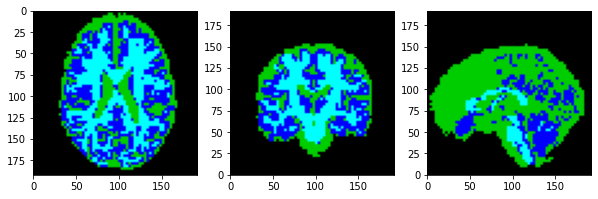

Predicted segmentation


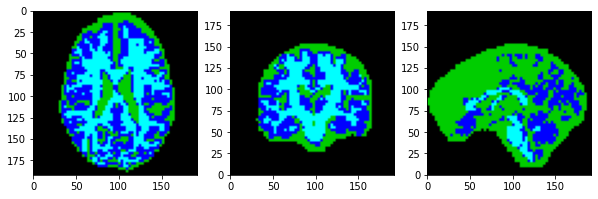

Calculating Features:   9%|▉         | 47/500 [00:00<00:00, 460.03it/s]


Finished TESTING.


Calculating Features: 100%|██████████| 500/500 [00:01<00:00, 445.13it/s]
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


START TESTING...test
+ TESTING 	Loss: 0.090309
+         	DSC: 0.8819443638283644


Reference segmentation


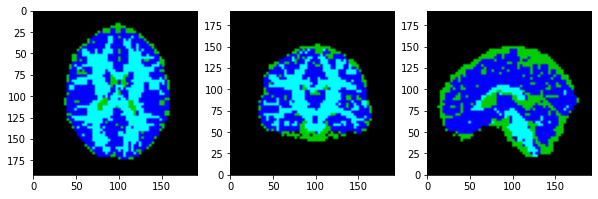

Predicted segmentation


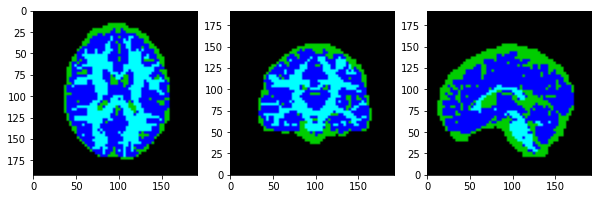

Calculating Features:  45%|████▌     | 45/100 [00:00<00:00, 444.26it/s]


Finished TESTING.


Calculating Features: 100%|██████████| 100/100 [00:00<00:00, 421.92it/s]


Final best
MAE: 7.891870926455781
R2: 0.7569374815357981
MVS: 0.7623597852341689
MSE: 91.91503930105995


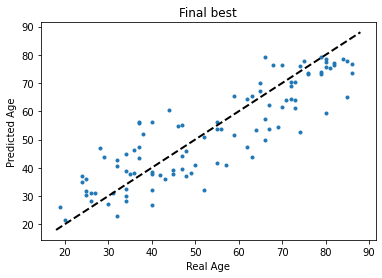

In [ ]:
########################################
# ADD YOUR CODE HERE
######################################## 
# Load trained unet
model = UNet3D(num_classes=num_classes)
model.load_state_dict(torch.load(os.path.join(model_dir, 'model.pt')))
model.to(device)
model.eval()
# Segment the 500 train data
load_and_segment(model, dataset_train, dataloader_train, "pred_500")
# Preprocess segmentations for regression
X, y = preprocess_for_regression("pred_500", "meta_data_regression_train")
# Train our best regression model using all 500 sample data
regressor = train_best_regressor_model(X, apply_log(y))
# Segment the test data
load_and_segment(model, dataset_test, dataloader_test, "test")
# Preprocess segmentations for regression
X_test, y_test = preprocess_for_regression("test", "meta_data_regression_test")
# Fit test segmentation with regression model
predicted = remove_log(regressor.predict(X_test))
# Evaluate scores
evaluate_results(y_test, predicted, "Final best")

## Part B: Age prediction using regression CNNs

For the second approach we will use a convolutional neural network to directly predict a subject's age.

You will need to implement a CNN model that takes an MRI scan as an input and maps it to a one-dimensional, real-valued output. A good starting point may be a LeNet-type architecture and adapt the last layers to convert the classification into a regression network. You should have all the necessary ingredients now from previous tasks and the notebooks from the lab tutorials for how to set up a CNN model in PyTorch, how to implement a suitable training and testing routine, and how to run a two-fold cross-validation on the 500 subjects similar to task A. For the final age prediction model, you should use all 500 subjects for training and you may want to use the 47 subjects that we used for training the tissue segmentation model as your validation data.

*Note:* Similar to task A, you may want to set up a pre-processing pipeline that involves intensity normalisation and resampling of the input data.

In [ ]:
########################################
# ADD YOUR CODE HERE
########################################